# Understanding Quantization in Deep Learning

This notebook provides a comprehensive understanding of quantization in deep learning, including both Post-Training Quantization (PTQ) and Quantization-Aware Training (QAT).

## Table of Contents
1. [Introduction to Quantization](#intro)
2. [Basic Concepts and Mathematics](#math)
3. [Toy Examples and Visualizations](#examples)
4. [Memory Usage Analysis](#memory)
5. [Computation Time Impact](#computation)
6. [Post-Training Quantization (PTQ)](#ptq)
7. [Quantization-Aware Training (QAT)](#qat)
8. [Real-world Applications](#applications)

In [25]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import sys
from IPython.display import display, Math

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    # Set default tensor type to cuda
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

Using device: cuda
GPU: NVIDIA GeForce GTX 1050
CUDA Version: 12.4


## Introduction to Quantization <a name="intro"></a>

Quantization is a technique used to reduce the precision of numbers in a neural network, typically converting 32-bit floating-point numbers to lower-precision formats like 8-bit integers. This process helps in:

1. Reducing model size
2. Decreasing memory bandwidth
3. Lowering computational requirements
4. Enabling deployment on edge devices

### Why Quantize?

Consider a simple example: storing the number π (3.14159...) in different formats:
- 32-bit float: ~4 bytes
- 8-bit integer: 1 byte

While we lose some precision, we gain significant memory savings.

### Types of Quantization

1. **Post-Training Quantization (PTQ)**:
   - Applied after training is complete
   - No retraining required
   - Faster to implement
   - May have more accuracy impact

2. **Quantization-Aware Training (QAT)**:
   - Quantization is simulated during training
   - Model learns to adapt to quantization
   - Better accuracy preservation
   - Requires full training/fine-tuning

## Basic Concepts and Mathematics <a name="math"></a>

### Linear Quantization Formula

The basic formula for linear quantization is:

$$q = \text{round}\left(\frac{r - r_{min}}{s}\right)$$

where:
- $q$ is the quantized value
- $r$ is the real (floating-point) value
- $r_{min}$ is the minimum value in the range
- $s$ is the scale factor (step size)

The scale factor is calculated as:

$$s = \frac{r_{max} - r_{min}}{2^n - 1}$$

where $n$ is the number of bits in the quantized format.

### Types of Quantization Schemes

1. **Uniform Quantization**: Uses equal-sized steps between quantization levels
   - Linear quantization: Maps values linearly between min and max
   - Symmetric: Uses symmetric ranges around zero
   - Asymmetric: Allows different ranges for positive and negative values

2. **Non-uniform Quantization**: Uses variable-sized steps
   - Logarithmic: Better precision for small values
   - K-means: Clusters values to optimize quantization levels

3. **Dynamic Range Quantization**: Adjusts ranges per tensor/layer
   - Per-tensor: One scale/zero-point per tensor
   - Per-channel: Different scales for each channel

### Quantization Parameters

1. **Scale**: Converts between float and integer representations
   - float_val = scale * (int_val - zero_point)
   - Determines the step size between quantized values

2. **Zero-point**: The integer value that represents 0 in float
   - Helps maintain the proper range mapping
   - Important for unsigned integer formats

# Understanding Zero Point and Scale in Post-Training Quantization (PTQ)

When we perform **Post-Training Quantization (PTQ)** on a neural network model, we convert high-precision numbers (like 32-bit floating point) to lower precision (like 8-bit integers). Two crucial concepts in this process are **Scale** and **Zero Point**. These help map the floating-point numbers to integers and vice versa, ensuring that the quantized model performs accurately.

## What is Scale?

**Scale** determines how much we need to multiply the integer values to get back to the original floating-point values. It essentially defines the step size between quantized levels.

### Mathematical Representation:
$$
\text{Scale} = \frac{\text{Max Float Value} - \text{Min Float Value}}{\text{Max Int Value} - \text{Min Int Value}}
$$

- **Max Float Value** and **Min Float Value**: The range of the floating-point numbers.
- **Max Int Value** and **Min Int Value**: The range of the integer representation (e.g., 0 to 255 for 8-bit unsigned integers).

## What is Zero Point?

**Zero Point** is the integer value that corresponds to the floating-point value of zero. It allows the quantized range to be asymmetric, meaning it doesn't have to be centered around zero.

### Mathematical Representation:
$$
\text{Zero Point} = \text{Round}\left(\frac{0 - \text{Min Float Value}}{\text{Scale}}\right)
$$

- **0**: The floating-point value we want to map to an integer.
- **Min Float Value**: The minimum value in the floating-point range.
- **Scale**: As defined above.

## Simple Examples to Illustrate Scale and Zero Point

Let's go through a simple example to understand how **Scale** and **Zero Point** work in PTQ.

### Example 1: Symmetric Quantization

**Scenario:**
- We have a floating-point range from -1.0 to 1.0.
- We want to quantize these values to 8-bit signed integers (range: -128 to 127).

**Calculations:**

1. **Calculate Scale:**
   $$
   \text{Scale} = \frac{1.0 - (-1.0)}{127 - (-128)} = \frac{2.0}{255} \approx 0.007843
   $$

2. **Calculate Zero Point:**
   $$
   \text{Zero Point} = 0 \quad \text{(since it's symmetric and centered around zero)}
   $$

3. **Quantize a Float Value (e.g., 0.5):**
   $$
   \text{Quantized Value} = \text{round}\left(\frac{0.5}{0.007843}\right) + 0 = \text{round}(63.75) = 64
   $$

4. **Dequantize to Verify:**
   $$
   \text{Dequantized Value} = (64 - 0) \times 0.007843 \approx 0.5016
   $$

**Interpretation:**
- The floating-point value **0.5** is approximated as the integer **64**.
- When dequantized, it becomes approximately **0.5016**, which is very close to the original value.

### Example 2: Asymmetric Quantization

**Scenario:**
- We have a floating-point range from 0.0 to 6.0.
- We want to quantize these values to 8-bit unsigned integers (range: 0 to 255).

**Calculations:**

1. **Calculate Scale:**
   $$
   \text{Scale} = \frac{6.0 - 0.0}{255 - 0} = \frac{6.0}{255} \approx 0.023529
   $$

2. **Calculate Zero Point:**
   $$
   \text{Zero Point} = \text{Round}\left(\frac{0 - 0.0}{0.023529}\right) = 0
   $$

3. **Quantize a Float Value (e.g., 3.0):**
   $$
   \text{Quantized Value} = \text{round}\left(\frac{3.0}{0.023529}\right) + 0 = \text{round}(127.5) = 128
   $$

4. **Dequantize to Verify:**
   $$
   \text{Dequantized Value} = (128 - 0) \times 0.023529 \approx 3.0
   $$

**Interpretation:**
- The floating-point value **3.0** is accurately represented as the integer **128**.
- When dequantized, it perfectly matches the original value of **3.0**.

### Example 3: Mapping with Non-Zero Zero Point

**Scenario:**
- We have a floating-point range from -2.0 to 2.0.
- We want to quantize these values to 8-bit unsigned integers (range: 0 to 255).

**Calculations:**

1. **Calculate Scale:**
   $$
   \text{Scale} = \frac{2.0 - (-2.0)}{255 - 0} = \frac{4.0}{255} \approx 0.015686
   $$

2. **Calculate Zero Point:**
   $$
   \text{Zero Point} = \text{Round}\left(\frac{0 - (-2.0)}{0.015686}\right) = \text{Round}(127.5) = 128
   $$

3. **Quantize a Float Value (e.g., 0.0):**
   $$
   \text{Quantized Value} = \text{round}\left(\frac{0.0}{0.015686}\right) + 128 = 0 + 128 = 128
   $$

4. **Dequantize to Verify:**
   $$
   \text{Dequantized Value} = (128 - 128) \times 0.015686 = 0.0
   $$

**Interpretation:**
- The floating-point value **0.0** is accurately represented as the integer **128**.
- When dequantized, it matches the original value of **0.0**.

## Summary

- **Scale** determines the step size between quantized integer values and is calculated based on the range of floating-point values and the integer range.
- **Zero Point** maps the floating-point zero to an integer value, allowing for asymmetric quantization where the integer range does not have to be symmetric around zero.
- **Quantization** and **Dequantization** use these two parameters to convert between floating-point and integer representations accurately.
- **Examples** demonstrate how specific floating-point values are mapped to integers and back, ensuring minimal loss of information.

Understanding **Scale** and **Zero Point** is fundamental to effectively applying PTQ, as they ensure that the quantized model maintains accuracy while benefiting from reduced computational and memory requirements.


In [26]:
def demonstrate_quantization(value, bits=8):
    """Demonstrate quantization of a single value"""
    # Define range
    r_min, r_max = -1.0, 1.0
    
    # Calculate scale factor
    s = (r_max - r_min) / (2**bits - 1)
    
    # Calculate zero point
    zero_point = round(-r_min / s)
    
    # Quantize
    q = np.round((value - r_min) / s)
    
    # Dequantize
    r_reconstructed = q * s + r_min
    
    print(f"Original value: {value}")
    print(f"Scale factor: {s:.6f}")
    print(f"Zero point: {zero_point}")
    print(f"Quantized value (integer): {int(q)}")
    print(f"Reconstructed value: {r_reconstructed}")
    print(f"Quantization error: {abs(value - r_reconstructed)}")

# Example usage
demonstrate_quantization(0.3456)

Original value: 0.3456
Scale factor: 0.007843
Zero point: 128
Quantized value (integer): 172
Reconstructed value: 0.34901960784313735
Quantization error: 0.003419607843137329


## Toy Examples and Visualizations <a name="examples"></a>

Let's create visual examples to understand different types of quantization effects.

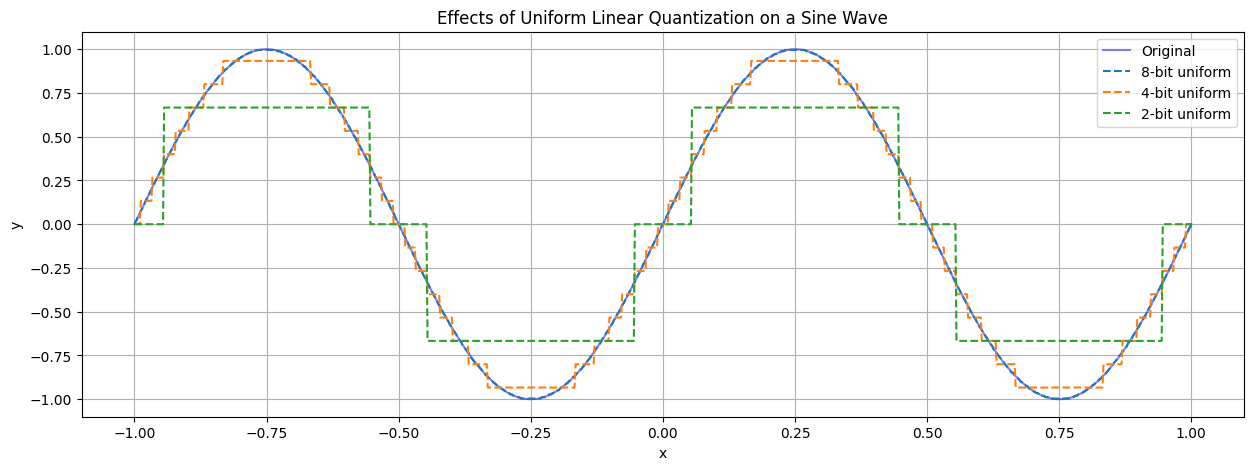

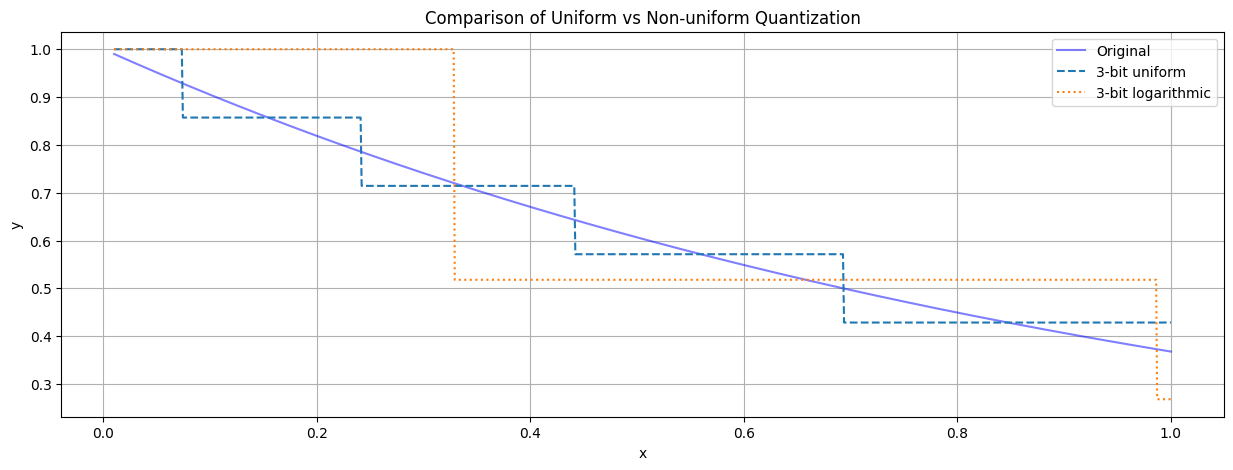

In [27]:
def plot_quantization_effects(bits_list=[8, 4, 2]):
    """Visualize the effects of different quantization levels using uniform linear quantization"""
    x = np.linspace(-1, 1, 1000)
    y = np.sin(2 * np.pi * x)  # Original function
    
    plt.figure(figsize=(15, 5))
    plt.plot(x, y, 'b-', label='Original', alpha=0.5)
    
    for bits in bits_list:
        # Uniform linear quantization parameters
        levels = 2**bits
        scale = 2.0 / (levels - 1)  # Symmetric range [-1, 1]
        
        # Quantize using uniform linear quantization
        y_quant = np.round(y / scale) * scale
        
        plt.plot(x, y_quant, '--', label=f'{bits}-bit uniform')
    
    plt.title('Effects of Uniform Linear Quantization on a Sine Wave')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_nonuniform_quantization(bits=3):
    """Demonstrate non-uniform (logarithmic) quantization"""
    x = np.linspace(0.01, 1, 1000)
    y = np.exp(-x)  # Original function
    
    # Uniform quantization
    levels = 2**bits
    scale = 1.0 / (levels - 1)
    y_uniform = np.round(y / scale) * scale
    
    # Logarithmic quantization
    log_y = np.log(y)
    log_scale = (np.log(1.0) - np.log(0.01)) / (levels - 1)
    y_log = np.exp(np.round(log_y / log_scale) * log_scale)
    
    plt.figure(figsize=(15, 5))
    plt.plot(x, y, 'b-', label='Original', alpha=0.5)
    plt.plot(x, y_uniform, '--', label=f'{bits}-bit uniform')
    plt.plot(x, y_log, ':', label=f'{bits}-bit logarithmic')
    
    plt.title('Comparison of Uniform vs Non-uniform Quantization')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Show both types of quantization
plot_quantization_effects()
plot_nonuniform_quantization()

### Ejercicio

Se entrega antes del siguiente miercoles

Aproxima una nueva funcion diferente a las sinoidal para entender como funciona la quantizacion. Reusa el caodigo anteriror pero agrega una nueva funcion

In [ ]:
### Tu codigo aqui

## Training and Quantizing a Simple Network

Let's create and train a simple neural network, then apply different quantization methods to understand their effects.

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time

def create_dataset(n_samples=1000, device='cuda'):
    """Create dataset and move to specified device"""
    X = torch.randn(n_samples, 10, device=device)
    weights = torch.randn(10, device=device)
    y = torch.sum(X * weights, dim=1) + torch.randn(n_samples, device=device) * 0.1
    return X, y.reshape(-1, 1)

class SimpleModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(10, 20)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(20, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class QAwareModel(torch.nn.Module):
    def __init__(self, input_size=10, hidden_size=20, output_size=1):
        super().__init__()
        self.quant = torch.quantization.QuantStub()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.dequant = torch.quantization.DeQuantStub()
        
    def forward(self, x):
        x = self.quant(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dequant(x)
        return x

In [90]:
def train_normal_model(epochs=10, batch_size=32, learning_rate=0.001, device='cuda'):
    """Train a normal model with specified parameters"""
    if not torch.cuda.is_available() and device == 'cuda':
        print("CUDA is not available. Falling back to CPU.")
        device = 'cpu'
    
    print(f"\nInitializing training on {device}")
    
    try:
        # Create dataset
        X, y = create_dataset(n_samples=1000, device=device)
        print("Dataset created successfully")
        
        # Initialize model and move to device
        model = SimpleModel()
        model = model.to(device)
        print("Model moved to device")
        
        # Create data loader with appropriate generator
        dataset = TensorDataset(X, y)
        if device == 'cuda':
            generator = torch.Generator(device=device)
            train_loader = DataLoader(
                dataset, 
                batch_size=batch_size, 
                shuffle=True,
                generator=generator
            )
        else:
            train_loader = DataLoader(
                dataset, 
                batch_size=batch_size, 
                shuffle=True
            )
        print("DataLoader created")
        
        # Training setup
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Training loop
        print("\nStarting training...")
        start_time = time.time()
        model.train()  # Set model to training mode
        
        for epoch in range(epochs):
            epoch_loss = 0.0
            batch_count = 0
            
            for batch_X, batch_y in train_loader:
                # Ensure data is on correct device
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                batch_count += 1
            
            if (epoch + 1) % 2 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/batch_count:.4f}')
        
        training_time = time.time() - start_time
        print(f"\nTraining completed in {training_time:.2f} seconds")
        
        return model, X, y, training_time
        
    except Exception as e:
        print(f"Error during training: {str(e)}")
        print("Stack trace:")
        import traceback
        traceback.print_exc()
        raise e

# Post-Training Quantization (PTQ)

Post-Training Quantization (PTQ) is a technique used in machine learning to make neural network models smaller and faster. It does this by converting the model's numbers from high precision (like 32-bit floating point) to lower precision (like 8-bit integers). This process helps the model run more efficiently, especially on devices with limited resources such as smartphones or IoT devices.

## How PTQ Works

### 1. **Model Training**
First, you start with a neural network that has been trained using high-precision numbers (usually 32-bit floating point). This model has learned to perform tasks like image recognition or language translation with good accuracy.

### 2. **Calibration**
Next, you use a small set of sample data (called calibration data) that represents the kind of data the model will see in real-world use. This step helps determine the range of values (minimum and maximum) for the model's weights and activations (the outputs of each layer in the network).

### 3. **Quantization**
In this step, the high-precision numbers in the model are converted to lower precision. This involves two main components:
- **Scale**: Determines how much to scale the floating-point numbers to fit into the lower precision range.
- **Zero Point**: Adjusts the range so that zero in floating-point maps correctly to zero in the integer representation.

The conversion formula looks like this:

$Quantized_Value = \text{round}\left(\frac{\text{Float Value}}{\text{Scale}}\right) + \text{Zero Point}$


### 4. **Inference with Quantized Model**
Once quantized, the model uses integer arithmetic for making predictions. Integer operations are typically faster and use less memory, which makes the model more efficient without significantly compromising accuracy.

## Benefits of PTQ

- **Efficiency**: Models run faster and consume less memory.
- **Resource Savings**: Enables deployment on devices with limited computational power and energy.
- **Convenience**: Can be applied to already trained models without needing to retrain them.

## Challenges of PTQ

- **Accuracy Loss**: Reducing precision can sometimes lead to a slight decrease in the model's accuracy.
- **Calibration Data Quality**: The effectiveness of PTQ depends on having good calibration data that accurately represents real-world usage.
- **Sensitive Layers**: Some parts of the model may be more affected by quantization and might require special handling.


In [101]:
def apply_ptq(model, X, device='cuda'):
    """Apply Post-Training Quantization to a model (CPU only version)"""
    start_time = time.time()
    print("Starting PTQ process (CPU-only mode)...")
    
    try:
        # Force everything to CPU and create new copies
        model_cpu = model.cpu()
        X_cpu = X.cpu()
        
        # Create quantization-ready model
        class QuantizedModel(torch.nn.Module):
            def __init__(self, original_model):
                super().__init__()
                # Force CPU initialization
                with torch.device('cpu'):
                    self.quant = torch.quantization.QuantStub()
                    # Create new layers instead of referencing original ones
                    self.fc1 = nn.Linear(
                        original_model.fc1.in_features,
                        original_model.fc1.out_features,
                        device='cpu'
                    )
                    self.relu = nn.ReLU()
                    self.fc2 = nn.Linear(
                        original_model.fc2.in_features,
                        original_model.fc2.out_features,
                        device='cpu'
                    )
                    self.dequant = torch.quantization.DeQuantStub()
                    
                    # Copy weights ensuring they're on CPU
                    self.fc1.weight.data = original_model.fc1.weight.data.cpu().clone()
                    self.fc1.bias.data = original_model.fc1.bias.data.cpu().clone()
                    self.fc2.weight.data = original_model.fc2.weight.data.cpu().clone()
                    self.fc2.bias.data = original_model.fc2.bias.data.cpu().clone()
            
            def forward(self, x):
                # Ensure input is on CPU
                x = x.cpu()
                x = self.quant(x)
                x = self.fc1(x)
                x = self.relu(x)
                x = self.fc2(x)
                x = self.dequant(x)
                return x
        
        # Create new quantization-ready model
        print("Creating quantization-ready model...")
        with torch.device('cpu'):
            new_model = QuantizedModel(model_cpu)
            new_model = new_model.cpu()
            new_model.eval()
        
        # Configure for static quantization
        print("Configuring static quantization...")
        new_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
        
        # Fuse operations (optional but recommended)
        print("Preparing model...")
        with torch.device('cpu'):
            model_prepared = torch.quantization.prepare(new_model)
        
        # Calibrate
        print("Calibrating...")
        with torch.no_grad():
            model_prepared = model_prepared.cpu()
            _ = model_prepared(X_cpu)
        
        # Convert to quantized model
        print("Converting to quantized model...")
        with torch.device('cpu'):
            quantized_model = torch.quantization.convert(model_prepared)
        
        print("Static quantization successful!")
        quantization_time = time.time() - start_time
        
        # Create a simple example to verify the model works
        print("\nVerifying quantized model...")
        with torch.no_grad():
            test_input = torch.randn(1, 10, device='cpu')
            quantized_model = quantized_model.cpu()
            test_output = quantized_model(test_input)
            print(f"Test inference successful! Output shape: {test_output.shape}")
        
        return quantized_model, "static", model.to(device), quantization_time
        
    except Exception as e:
        print(f"Quantization failed: {str(e)}")
        print("Stack trace:")
        import traceback
        traceback.print_exc()
        return None, None, model.to(device), time.time() - start_time

# Quantization-Aware Training (QAT) Explained

**Quantization-Aware Training (QAT)** is a sophisticated technique in machine learning used to optimize neural network models for deployment on resource-constrained devices. Unlike Post-Training Quantization (PTQ), which applies quantization after the model has been trained, QAT integrates the quantization process into the training phase itself. This approach allows the model to learn and adapt to the lower precision representations during training, often resulting in higher accuracy and better performance in the quantized model.

## Why Use Quantization-Aware Training?

Quantization reduces the precision of the numbers used to represent a model's parameters and computations, typically converting from 32-bit floating-point to 8-bit integers. This reduction leads to:

- **Smaller Model Size**: Lower precision numbers consume less memory, enabling models to fit on devices with limited storage.
- **Faster Inference**: Integer arithmetic operations are generally faster and more efficient on specialized hardware, leading to quicker model predictions.
- **Lower Power Consumption**: Reduced computational requirements translate to lower energy usage, which is crucial for battery-powered devices.

However, quantization can introduce errors that may degrade the model's accuracy. QAT addresses this by making the model aware of these quantization effects during training, allowing it to adjust its weights and activations to minimize accuracy loss.

## How Does QAT Work?

### 1. **Model Initialization**
Begin with a neural network model that you intend to train or fine-tune for a specific task.

### 2. **Insert Quantization Operations**
During the training process, insert *fake quantization* operations into the model. These operations simulate the effects of quantization (such as reduced precision) without permanently altering the weights. They allow gradients to flow through the network, enabling the model to learn how to compensate for quantization errors.

### 3. **Training with Quantization Awareness**
Train the model as usual. The presence of quantization operations forces the model to adapt its weights and activations to be robust against the distortions introduced by lower precision. This step ensures that the model maintains high accuracy even after quantization.

### 4. **Convert to Quantized Model**
After training, replace the fake quantization operations with actual quantization parameters (scale and zero point) to produce the final quantized model ready for deployment.

## Key Concepts in QAT

### **Scale and Zero Point**

Similar to PTQ, QAT utilizes **Scale** and **Zero Point** to map floating-point numbers to integers and vice versa:

- **Scale**: Determines the step size between quantized levels.
- **Zero Point**: Maps the floating-point zero to an integer value, allowing for asymmetric quantization.

### **Fake Quantization**

During training, fake quantization simulates the quantization process by quantizing and dequantizing tensors. This simulation helps the model learn to handle the reduced precision without permanently changing the weights, preserving the ability to perform backpropagation effectively.

## Benefits of QAT

- **Higher Accuracy**: By training the model with quantization in mind, QAT typically results in better accuracy compared to PTQ, especially for models sensitive to precision loss.
- **Robustness to Quantization Errors**: The model learns to adjust its parameters to mitigate the impact of quantization, making it more resilient to errors introduced by lower precision.
- **Efficient Deployment**: Enables the creation of models that are both efficient and accurate, suitable for deployment on edge devices with limited computational resources.

## Challenges and Considerations

- **Increased Training Complexity**: QAT requires modifying the training pipeline to include quantization operations, adding complexity to the training process.
- **Longer Training Time**: Incorporating quantization into training can extend the overall training duration.
- **Need for Training Data**: Unlike PTQ, which can be applied post hoc, QAT necessitates access to the training data and pipeline, making it less flexible for already trained models.

## QAT vs. PTQ

| Feature                  | Post-Training Quantization (PTQ)       | Quantization-Aware Training (QAT)         |
|--------------------------|----------------------------------------|--------------------------------------------|
| **Application Timing**   | After model training                   | During model training                      |
| **Training Required**    | No                                     | Yes                                        |
| **Accuracy Impact**      | Potentially higher accuracy loss       | Generally retains higher accuracy          |
| **Complexity**           | Simpler to apply to existing models    | More complex, requires training modifications |
| **Use Case**             | Quick optimization for already trained models | Optimizing models with potential for retraining |

## Example Scenario: QAT in Practice

Imagine you have a convolutional neural network (CNN) trained for image classification. You aim to deploy this model on a smartphone, where computational resources and memory are limited. Applying PTQ might reduce the model size and inference time, but it could also lead to a noticeable drop in classification accuracy.

By using QAT, you integrate quantization into the training process. As the model trains, it learns to adjust its weights and activations to account for the lower precision. The result is a quantized model that maintains accuracy close to the original floating-point model while benefiting from reduced size and faster inference, making it ideal for deployment on the smartphone.

## Summary

**Quantization-Aware Training (QAT)** is a powerful technique for optimizing neural network models by incorporating quantization into the training process. By making the model aware of the quantization effects during training, QAT ensures that the final quantized model maintains high accuracy and performs efficiently on various hardware platforms. While it introduces additional complexity and training requirements compared to PTQ, the benefits in terms of model performance and deployment efficiency make QAT an essential tool for deploying machine learning models in real-world, resource-constrained environments.

Understanding QAT, along with its key components like **Scale** and **Zero Point**, empowers students and practitioners to build models that are both accurate and efficient, suitable for deployment on a wide range of devices.

In [93]:
def apply_qat(model, X, y, epochs=10, batch_size=32, learning_rate=0.001, device='cuda'):
    """Apply Quantization-Aware Training with the same hyperparameters as normal training"""
    start_time = time.time()
    
    try:
        print("\nStarting QAT process:")
        
        # Create QAT model
        qat_model = QAwareModel(
            input_size=model.fc1.in_features,
            hidden_size=model.fc1.out_features,
            output_size=model.fc2.out_features
        ).to(device)  # Start on CUDA
        
        # Copy weights while on CUDA
        qat_model.fc1.weight.data = model.fc1.weight.data.clone()
        qat_model.fc1.bias.data = model.fc1.bias.data.clone()
        qat_model.fc2.weight.data = model.fc2.weight.data.clone()
        qat_model.fc2.bias.data = model.fc2.bias.data.clone()
        
        # Create dataset with data on GPU
        dataset = TensorDataset(X, y)
        
        # Create data loader with CUDA generator
        g = torch.Generator(device=device)
        g.manual_seed(42)
        train_loader = DataLoader(
            dataset, 
            batch_size=batch_size, 
            shuffle=True,
            generator=g
        )
        
        # Now move to CPU for quantization preparation
        qat_model = qat_model.cpu()
        
        # Configure for QAT
        qat_model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
        qat_model = torch.quantization.prepare_qat(qat_model)
        
        # Training setup
        criterion = nn.MSELoss()
        optimizer = optim.Adam(qat_model.parameters(), lr=learning_rate)
        
        # Training loop
        print("Training QAT model...")
        qat_model.train()
        
        for epoch in range(epochs):
            epoch_loss = 0.0
            batch_count = 0
            
            for batch_X, batch_y in train_loader:
                # Move batch to CPU for quantization training
                batch_X = batch_X.cpu()
                batch_y = batch_y.cpu()
                
                optimizer.zero_grad()
                outputs = qat_model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                batch_count += 1
            
            if (epoch + 1) % 2 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/batch_count:.4f}')
        
        # Convert to quantized model
        qat_model.eval()
        quantized_model = torch.quantization.convert(qat_model)
        print("QAT completed successfully.")
        
        training_time = time.time() - start_time
        return quantized_model, model.to(device), training_time
        
    except Exception as e:
        print(f"Error during QAT: {str(e)}")
        print("Stack trace:")
        import traceback
        traceback.print_exc()
        return None, model.to(device), time.time() - start_time

In [97]:
def compare_models(normal_model, ptq_model, qat_model, X, y, normal_time, ptq_time, qat_time, device='cuda'):
    """Compare all model variants"""
    print("=" * 50)
    print("Model Comparison Results")
    print("=" * 50)
    
    try:
        # Move data to appropriate devices
        X_cuda = X.to(device)
        y_cuda = y.to(device)
        X_cpu = X.cpu()
        y_cpu = y.cpu()
        
        # Ensure models are on correct devices
        normal_model = normal_model.to(device)
        # PTQ and QAT models stay on CPU
        
        # Calculate sizes
        normal_size = sum(p.nelement() * p.element_size() for p in normal_model.parameters())
        
        if ptq_model is not None:
            ptq_size = sum(p.nelement() * p.element_size() for p in ptq_model.state_dict().values() 
                          if isinstance(p, torch.Tensor))
        else:
            ptq_size = float('inf')
            
        if qat_model is not None:
            qat_size = sum(p.nelement() * p.element_size() for p in qat_model.state_dict().values() 
                          if isinstance(p, torch.Tensor))
        else:
            qat_size = float('inf')
        
        # Evaluate models
        criterion = nn.MSELoss()
        
        with torch.no_grad():
            # Normal model evaluation (on CUDA)
            normal_output = normal_model(X_cuda)
            normal_loss = criterion(normal_output, y_cuda)
            
            # PTQ evaluation (on CPU)
            if ptq_model is not None:
                try:
                    ptq_output = ptq_model(X_cpu)
                    ptq_output = ptq_output.to(device)
                    ptq_loss = criterion(ptq_output, y_cuda)
                    ptq_error = torch.abs(normal_output - ptq_output)
                    ptq_success = True
                except Exception as e:
                    print(f"Warning: PTQ evaluation failed: {str(e)}")
                    ptq_success = False
            else:
                ptq_success = False
            
            # QAT evaluation (on CPU)
            if qat_model is not None:
                try:
                    qat_output = qat_model(X_cpu)
                    qat_output = qat_output.to(device)
                    qat_loss = criterion(qat_output, y_cuda)
                    qat_error = torch.abs(normal_output - qat_output)
                    qat_success = True
                except Exception as e:
                    print(f"Warning: QAT evaluation failed: {str(e)}")
                    qat_success = False
            else:
                qat_success = False
        
        # Print results
        print("\nModel Sizes:")
        print(f"Normal model: {normal_size/1024:.2f} KB")
        
        if ptq_success:
            print(f"PTQ model: {ptq_size/1024:.2f} KB (ratio: {normal_size/ptq_size:.2f}x)")
        else:
            print("PTQ model: Failed to evaluate")
            
        if qat_success:
            print(f"QAT model: {qat_size/1024:.2f} KB (ratio: {normal_size/qat_size:.2f}x)")
        else:
            print("QAT model: Failed to evaluate")
        
        print("\nTraining/Conversion Times:")
        print(f"Normal training: {normal_time:.2f} seconds")
        print(f"PTQ conversion: {ptq_time:.2f} seconds")
        print(f"QAT training: {qat_time:.2f} seconds")
        
        print("\nAccuracy Metrics:")
        print(f"Normal model loss: {normal_loss.item():.6f}")
        
        if ptq_success:
            print(f"PTQ model loss: {ptq_loss.item():.6f}")
            print(f"PTQ - Mean error: {ptq_error.mean().item():.6f}")
            print(f"PTQ - Max error: {ptq_error.max().item():.6f}")
        
        if qat_success:
            print(f"QAT model loss: {qat_loss.item():.6f}")
            print(f"QAT - Mean error: {qat_error.mean().item():.6f}")
            print(f"QAT - Max error: {qat_error.max().item():.6f}")
        
        # Recommendations
        print("\nRecommendations:")
        working_models = []
        if ptq_success:
            working_models.append(("PTQ", ptq_loss.item(), ptq_size))
        if qat_success:
            working_models.append(("QAT", qat_loss.item(), qat_size))
            
        if working_models:
            # Best accuracy
            best_accuracy = min(working_models, key=lambda x: x[1])
            print(f"→ {best_accuracy[0]} achieved best accuracy")
            
            # Best compression
            best_compression = min(working_models, key=lambda x: x[2])
            print(f"→ {best_compression[0]} achieved best compression")
        else:
            print("No quantization method was successfully evaluated")
            
    except Exception as e:
        print(f"Error during comparison: {str(e)}")
        print("Stack trace:")
        import traceback
        traceback.print_exc()

In [103]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


try:
    # Train normal model
    normal_model, X, y, normal_time = train_normal_model(
        epochs=10,
        batch_size=32,
        learning_rate=0.001,
        device=device
    )

    # Apply PTQ
    ptq_model, ptq_type, _, ptq_time = apply_ptq(normal_model, X, device)

    # Apply QAT
    qat_model, _, qat_time = apply_qat(
        normal_model,
        X,
        y,
        epochs=10,
        batch_size=32,
        learning_rate=0.001,
        device=device
    )

    # Compare models
    if ptq_model is not None and qat_model is not None:
        compare_models(
            normal_model,
            ptq_model,
            qat_model,
            X,
            y,
            normal_time,
            ptq_time,
            qat_time,
            device
        )
    else:
        print("One or more quantization methods failed. Check the error messages above.")

except Exception as e:
    print(f"Error in comparison: {str(e)}")
    print("Stack trace:")
    import traceback
    traceback.print_exc()

Using device: cuda

Initializing training on cuda
Dataset created successfully
Model moved to device
DataLoader created

Starting training...
Epoch [2/10], Loss: 2.5570
Epoch [4/10], Loss: 1.4168
Epoch [6/10], Loss: 0.5392
Epoch [8/10], Loss: 0.1754
Epoch [10/10], Loss: 0.0874

Training completed in 0.61 seconds
Starting PTQ process (CPU-only mode)...
Creating quantization-ready model...
Configuring static quantization...
Preparing model...
Calibrating...
Converting to quantized model...
Static quantization successful!

Verifying quantized model...
Test inference successful! Output shape: torch.Size([1, 1])

Starting QAT process:
Training QAT model...
Epoch [2/10], Loss: 0.0904
Epoch [4/10], Loss: 0.0834
Epoch [6/10], Loss: 0.0841
Epoch [8/10], Loss: 0.0823
Epoch [10/10], Loss: 0.0809
QAT completed successfully.
Model Comparison Results

Model Sizes:
Normal model: 0.94 KB
PTQ model: 0.04 KB (ratio: 26.78x)
QAT model: 0.04 KB (ratio: 26.78x)

Training/Conversion Times:
Normal training: 

## Real-world Applications <a name="applications"></a>

Common use cases for quantization:

1. **Mobile Deployment**: Reducing model size for mobile apps
2. **Edge Computing**: Enabling inference on resource-constrained devices
3. **Cloud Cost Reduction**: Decreasing memory and computation requirements
4. **Real-time Applications**: Improving inference speed

### Best Practices

1. Start with PTQ as it's simpler to implement
2. Use QAT if PTQ doesn't meet accuracy requirements
3. Always validate accuracy after quantization
4. Consider hardware compatibility
5. Monitor both model size and inference speed
6. When using GPU acceleration:
   - Consider mixed-precision training (FP16) for faster training
   - Use GPU-specific quantization features when available
   - Profile memory usage and computation time on target hardware

### Quantization Tips

1. **Model Architecture**:
   - Some layers are more quantization-friendly than others
   - Consider quantization during model design
   - Avoid operations that are difficult to quantize

2. **Calibration Data**:
   - Use representative data for calibration
   - Ensure sufficient variety in calibration samples
   - Consider data distribution

3. **Error Analysis**:
   - Monitor accuracy degradation
   - Analyze per-layer quantization effects
   - Consider layer-wise precision requirements

## Ejercicio


# Student Assessment: Post-Training Quantization (PTQ) and Quantization-Aware Training (QAT)

This assessment is designed to evaluate your understanding of Post-Training Quantization (PTQ) and Quantization-Aware Training (QAT). It includes both conceptual questions and simple coding exercises to reinforce your knowledge of these quantization techniques in machine learning.

## **Conceptual Questions**

1. **Compare PTQ and QAT:**
   - **Question:** Describe the key differences between Post-Training Quantization (PTQ) and Quantization-Aware Training (QAT) in terms of their workflows and impact on model accuracy.
   - **Objective:** Understand the distinct processes and advantages of each quantization method.

2. **Scale and Zero Point:**
   - **Question:** Explain how the **Scale** and **Zero Point** parameters influence the quantization process. Why are they important for maintaining model accuracy?
   - **Objective:** Grasp the fundamental concepts that enable accurate mapping between floating-point and integer representations.

3. **Benefits and Drawbacks:**
   - **Question:** What are the primary benefits and potential drawbacks of using QAT over PTQ?
   - **Objective:** Evaluate the trade-offs involved in choosing between QAT and PTQ for model optimization.

4. **When to Use PTQ vs. QAT:**
   - **Question:** Provide a scenario where PTQ would be more suitable than QAT, and another scenario where QAT would be the preferred choice.
   - **Objective:** Identify practical applications and decision-making criteria for selecting the appropriate quantization technique.

5. **Fake Quantization in QAT:**
   - **Question:** How does fake quantization in QAT help in maintaining the accuracy of the neural network model?
   - **Objective:** Understand the role of fake quantization in simulating quantization effects during training.

6. **Impact on Model Deployment:**
   - **Question:** Discuss how PTQ and QAT affect the deployment of machine learning models on edge devices. Consider factors like model size, inference speed, and power consumption.
   - **Objective:** Relate quantization techniques to real-world deployment considerations.

